<a href="https://colab.research.google.com/github/LarsHadidi/PRONTO/blob/mathprogram/mp/PDP-MCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progressive Dinner Party: Monte Carlo Method

# Method: Improving initial solution with Simulated Annealing

[Simulated Annealing](https://en.wikipedia.org/wiki/Simulated_annealing) is a metaheuristic to approximate global optimization in a large search space. The method is an adaptation of the [Metropolis–Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), a Monte Carlo method to generate sample states of a thermodynamic system. The state of some physical systems, and the function E(s) to be minimized, is analogous to the internal energy of the system in that state. The goal is to bring the system, from an arbitrary initial state, to a state with the minimum possible energy.

<img src="https://camo.githubusercontent.com/3fd642eaa35c9ebfb9389cd4ba7d818285e932f710eb7bdd88833326a49543fb/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f382f38642f53696d756c61746564416e6e65616c696e67536c6f772e6a7067" alt="SimAnneal" width="25%"/>

## Hosted Runtime

In [1]:
!pip install -q simanneal

## Imports

In [2]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from scipy import spatial
from simanneal import Annealer
from matplotlib import pyplot as plt

## Data

In [13]:
with open('G.p', 'rb') as f:
    G = pickle.load(f)
t = pd.read_csv('csp-solution.csv', index_col=0)
n = len(t.columns)
X = list(nx.get_node_attributes(G, 'x').values())
Y = list(nx.get_node_attributes(G, 'y').values())
C = spatial.distance.squareform(spatial.distance.pdist(list(zip(X,Y)), metric='euclidean'))
pd.DataFrame(t)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,30,30,45,30,27,27,42,27,45,24,...,33,6,6,33,6,3,3,36,3,33
1,28,44,28,26,41,26,28,44,26,22,...,8,4,32,4,2,35,2,4,32,2
2,43,29,29,40,29,43,25,25,25,43,...,7,31,5,5,34,5,31,1,1,1


## Implementation

In [14]:
def objective(𝚷: list, T: np.array, C: np.array):
  N = len(C)
  
  S = T[0,:]
  M = T[1,:]
  D = T[2,:]

  p_S = [𝚷[T[0,i]-1] for i in range(N)]
  p_M = [𝚷[T[1,i]-1] for i in range(N)]
  p_D = [𝚷[T[2,i]-1] for i in range(N)]

  return sum([C[p_S[i],p_M[i]] + C[p_M[i],p_D[i]] for i in range(N)])

In [15]:
class Permutation(Annealer):
  def __init__(self, state: list, C: np.array, T: np.array):
    self.C = C
    self.T = T
    super(Permutation, self).__init__(state)
  
  def move(self):
    a = np.random.randint(0, len(self.state) - 1)
    b = np.random.randint(0, len(self.state) - 1)
    self.state[a], self.state[b] = self.state[b], self.state[a]
  
  def energy(self):
    energy = objective(self.state, T, C)
    return energy

In [16]:
T = np.array(t)
permutation = Permutation(list(range(n)), C, T)

permutation.Tmax = 500
permutation.Tmin = 0.01
permutation.steps = 1e5
permutation.copy_strategy = 'slice'
permutation.updates = 10
permutation.update = lambda step, T, E, A, I: print(f'{T:12.5f}\t{E:12.2f}\t{float(A or 0)*100.0:7.2f}\t{float(I or 0)*100.0:7.2f}')

In [17]:
print(f'{"Temperature": >12}\t{"Energy": >12}\t{"Accept": >7}\t{"Improve": >7}')
𝚷, y = permutation.anneal()
print(f'Annealed objective value: {y}')

 Temperature	      Energy	 Accept	Improve
   500.00000	       16.25	   0.00	   0.00
   169.46226	       16.29	  99.98	  48.63
    57.43492	       16.03	  99.86	  48.11
    19.46610	       16.27	  99.75	  48.42
     6.59754	       15.61	  99.17	  48.76
     2.23607	       17.05	  97.10	  47.14
     0.75786	       16.01	  91.29	  44.64
     0.25686	       14.94	  76.11	  36.57
     0.08706	       10.81	  42.72	  20.55
     0.02951	        8.83	  16.01	   6.65
     0.01000	        8.08	   5.75	   1.80
Annealed objective value: 8.06688921928144


## Results

In [18]:
def draw_graph(nodes: dict, edges: list):
	G = nx.DiGraph()
	G.add_nodes_from(nodes)
	G.add_edges_from(edges)
	pos = {k: list(v.values()) for k, v in nodes.items()}
	edge_colors = nx.get_edge_attributes(G,'color').values()
	node_colors = np.array(list(dict(G.in_degree(G.nodes)).values())) - np.array(list(dict(G.out_degree(G.nodes)).values()))
  

	nx.draw(
			G, pos,
			edge_color = edge_colors,
			edge_cmap = plt.cm.get_cmap('Set3'),
			node_color = node_colors,
			width=3, node_size=50, connectionstyle='arc3,rad=0.1')
	plt.show()

### Initial Solution

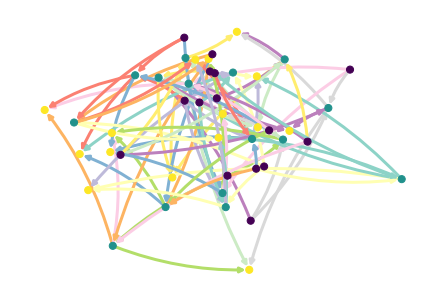

In [19]:
nodes = dict(G.nodes(data=True))
edges = []
for m in range(n):
    edges.append((T[0,m]-1, T[1,m]-1, {'color':m}))
    edges.append((T[1,m]-1, T[2,m]-1, {'color':m}))
node_colors = np.array(list(dict(G.in_degree(G.nodes)).values()))-np.array(list(dict(G.out_degree(G.nodes)).values()))
draw_graph(nodes, edges)

### Annealed Solution

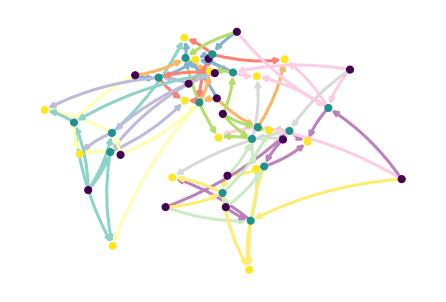

In [20]:
nodes = dict(G.nodes(data=True))
edges = []
for m in range(n):
    edges.append((𝚷[T[0,m]-1], 𝚷[T[1,m]-1], {'color':m}))
    edges.append((𝚷[T[1,m]-1], 𝚷[T[2,m]-1], {'color':m}))
node_colors = np.array(list(dict(G.in_degree(G.nodes)).values()))-np.array(list(dict(G.out_degree(G.nodes)).values()))
draw_graph(nodes, edges)